## Recurrent Neural Networks
In this homework, we will explore how to develop a simple Recurrent Neural Network (RNN) for sentiment analysis. As a dataset, we will use the IMDB dataset. It contains the text of some reviews and the sentiment given by the authors of the reviews (positive review or negative review). The input to the RNN is the sequence of words that compose a review. The learning task consists in predicting the sentiment of the review.
In the first part, we will learn how to develop a simple RNN, then we will explore the differences in terms of computational load, number of parameters, and performances with respect to more advanced recurrent models, like LSTM and GRU. Subsequently, we experiment with the bi-directional model to unveil the strengths and the weaknesses of this technique. Finally, we will explore how to face overfitting by Dropout. 

In [ ]:
#######################################################
# Plots for accuracy and loss in Train and Validation #
#######################################################

def plot_accuracy_loss(history_l, K, parameters = None):
    plt.figure(figsize=(20, 7))
    colors = ["red", "blue", "orange", "green", "cyan"]
    #Plot accuracy
    plt.subplot(1, 2, 1)
    plt.title('Train and Validation Accuracy by Epochs')
    plt.xlabel('Epochs', fontweight='bold', fontsize=15)
    plt.ylabel('Accuracy', fontweight='bold', fontsize=15)
    for i in range(0, K):
      plt.plot(history_l[i].history['accuracy'], label = 'Train Accuracy ' + str(parameters[i]), color = colors[i])
      plt.plot(history_l[i].history['val_accuracy'], label = 'Validation Accuracy ' + str(parameters[i]), color = colors[i], linestyle = ":")
      plt.legend(fontsize='medium')
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.title('Train and Validation Loss by Epochs')
    plt.xlabel('Epochs', fontweight='bold', fontsize=15)
    plt.ylabel('Loss', fontweight='bold', fontsize=15)
    for i in range(0, K):
      plt.plot(history_l[i].history['loss'], label = 'Train Accuracy Loss ' + str(parameters[i]), color = colors[i])
      plt.plot(history_l[i].history['val_loss'], label = 'Validation Accuracy Loss ' + str(parameters[i]), color = colors[i], linestyle = ":")
      plt.legend(fontsize='medium')
    plt.show()

##Simple RNN

Let's start by importing Tensorflow, Keras and Numpy

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

np.random.seed(42)

###Load dataset:
In this HW, we use the same datset used in the HW2, the IMDB dataset. The dataset contains 50,000 movie reviews from IMDB, labeled by sentiment (positive/negative). Reviews have been preprocessed, and each review is encoded as a sequence of word indexes. For convenience, the words are indexed by the overall frequency in the dataset, so that for example the integer "3" encodes the 3rd most frequent word in the data. For testing purposes, we will only consider the first 10,000  most common words.
By default, the load_data method returns a breakdown of the dataset into training and test sets. Both these sets contain 25,000 samples. To also have a validation set, we split the test set in half.

In [ ]:

num_words = 10000
(X_train, y_train), (X_test, y_test) = keras.datasets.imdb.load_data(num_words=num_words)
(X_valid, X_test) = X_test[:12500], X_test[12500:]
(y_valid, y_test) = y_test[:12500], y_test[12500:]

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

Let's also get the word indexs (word to word-id)

In [ ]:
word_index = keras.datasets.imdb.get_word_index()

Now we create a reverse index (word-id to word) method. Moreover, we add three special word-ids to encode:
- the padding;
- the start of a sequence;
- a word that is not in the vocabulary of the first 10,000 most common words.

Moreover, we also add an "unknown" placeholder for all the other symbols (not words) that may occur.
*Please, notice that Keras does not use index 0, so we can shift the indices only by 3 positions.*

In [ ]:
reverse_index = {word_id + 3: word for word, word_id in word_index.items()}
reverse_index[0] = "<pad>" # padding
reverse_index[1] = "<sos>" # start of sequence
reverse_index[2] = "<oov>" # out-of-vocabulary
reverse_index[3] = "<unk>" # unknown

def decode_review(word_ids):
    return " ".join([reverse_index.get(word_id, "<err>") for word_id in word_ids])

In [ ]:
print(reverse_index)

{34704: 'fawn', 52009: 'tsukino', 52010: 'nunnery', 16819: 'sonja', 63954: 'vani', 1411: 'woods', 16118: 'spiders', 2348: 'hanging', 2292: 'woody', 52011: 'trawling', 52012: "hold's", 11310: 'comically', 40833: 'localized', 30571: 'disobeying', 52013: "'royale", 40834: "harpo's", 52014: 'canet', 19316: 'aileen', 52015: 'acurately', 52016: "diplomat's", 25245: 'rickman', 6749: 'arranged', 52017: 'rumbustious', 52018: 'familiarness', 52019: "spider'", 68807: 'hahahah', 52020: "wood'", 40836: 'transvestism', 34705: "hangin'", 2341: 'bringing', 40837: 'seamier', 34706: 'wooded', 52021: 'bravora', 16820: 'grueling', 1639: 'wooden', 16821: 'wednesday', 52022: "'prix", 34707: 'altagracia', 52023: 'circuitry', 11588: 'crotch', 57769: 'busybody', 52024: "tart'n'tangy", 14132: 'burgade', 52026: 'thrace', 11041: "tom's", 52028: 'snuggles', 29117: 'francesco', 52030: 'complainers', 52128: 'templarios', 40838: '272', 52031: '273', 52133: 'zaniacs', 34709: '275', 27634: 'consenting', 40839: 'snuggle

Let's print a training sample and its target value

In [ ]:
decode_review(X_train[0])

"<sos> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <oov> is an amazing actor and now the same being director <oov> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <oov> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <oov> to the two little boy's that played the <oov> of norman and paul they were just brilliant children are often left out of the <oov> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what

In [ ]:
y_train[0]

1

Because of a limit of Keras, to feed the input data into an RNN model we have to create sequences that have the same length. We use keras.preprocessing.sequence.pad_sequences() to preprocess X_train: this will create a 2D array of 25,000 rows (one per review) and maxlen=500 columns. Because of that, reviews longer than 500 words will be cut, while reviews shorter than 500 words will be padded with zeros.

In [ ]:
maxlen = 500
X_train_trim = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test_trim = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)
X_valid_trim = keras.preprocessing.sequence.pad_sequences(X_valid, maxlen=maxlen)

###Define the model:
Let's define the model: 
- The first layer is an Embedding layer, with input_dim=num_words and output_dim=10. The model will gradually learn to represent each of the 10,000 words as a 10-dimensional vector. So the next layer will receive 3D batches of shape (batch size, 500, 10)
- The second layer is the recurrent one. In particular, in this case, we use a [SimpleRNN](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN) 
- The output layer is a Dense layer with a sigmoid activation function since this is a binary classification problem

In the following cell, we already inserted in the model the first Embedding layer. Add the recurrent layer (using 32 units), and the output layer. Select the right activation function for the output layer and motivate your choice. Finally, select the right loss function inserting the right value for the "loss" parameter in model.compile() and motivate your choice.
Please, insert your answers in a new text cell below this one, immediately before the code.

I chose the 'binary_crossentropy' because this is a binary classification problem and so it would make no sense to use the categorical_crossentropy loss. Instead, for the output activation layer, I choose as activaction function the 'sigmoid'. Thanks to this activation, the model output represents the probability of an example to belong to one of the two classes (the output is bounded between zero and one by the sigmoid).




###Train the model:
Now we have to train the model

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Embedding(input_dim = num_words, output_dim=10))
model.add(tf.keras.layers.SimpleRNN(units = 32, activation = 'sigmoid'))
model.add(tf.keras.layers.Dense(units = 1, activation = 'sigmoid'))

model.compile(loss = "binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(X_train_trim, y_train,
                    epochs=5, batch_size=128, validation_data=(X_valid_trim, y_valid))
evolution_act.append(history)
scores = model.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))


Epoch 1/5
196/196 [==============================] - 64s 322ms/step - loss: 0.7049 - accuracy: 0.5158 - val_loss: 0.6759 - val_accuracy: 0.6039
Epoch 2/5
196/196 [==============================] - 63s 323ms/step - loss: 0.6559 - accuracy: 0.6502 - val_loss: 0.6281 - val_accuracy: 0.6375
Epoch 3/5
196/196 [==============================] - 63s 321ms/step - loss: 0.5601 - accuracy: 0.7270 - val_loss: 0.4924 - val_accuracy: 0.7770
Epoch 4/5
196/196 [==============================] - 63s 321ms/step - loss: 0.3992 - accuracy: 0.8239 - val_loss: 0.4565 - val_accuracy: 0.7994
Epoch 5/5
196/196 [==============================] - 63s 321ms/step - loss: 0.3629 - accuracy: 0.8474 - val_loss: 0.4863 - val_accuracy: 0.7790
391/391 - 10s - loss: 0.4657 - accuracy: 0.7887
accuracy: 78.87%


In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 10)          100000    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 32)                1376      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 101,409
Trainable params: 101,409
Non-trainable params: 0
_________________________________________________________________


Print the values of accuracy and the loss , and evaluate the model on the test set

391/391 - 10s - loss: 0.4657 - accuracy: 0.7887
accuracy: 78.87%


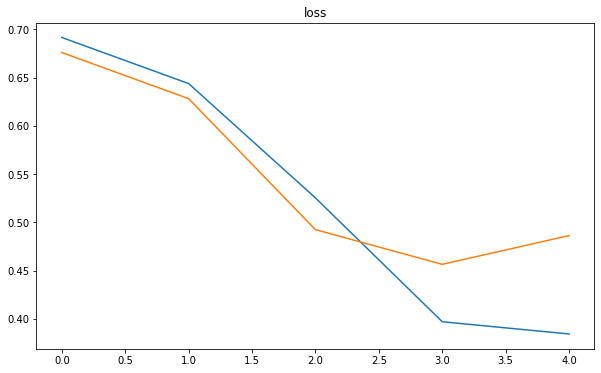

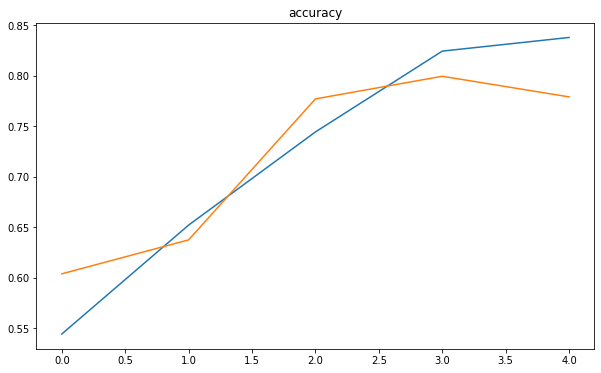

In [ ]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['loss'])
  plt.plot(history.epoch,history.history['val_loss'])
  plt.title('loss')

def plot_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['accuracy'])
  plt.plot(history.epoch,history.history['val_accuracy'])
  plt.title('accuracy')



plot_loss(history)

plot_accuracy(history)

scores = model.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

##LSTM and GRU
In this Exercise, you have to implement 2 models, similar to the previous one that, instead of exploiting the RNN layer, use an LSTM and a GRU Layer, respectively. For each model print the summary. Then, train it and plot the values of accuracy and loss. Finally, discuss the differences in terms of performance, the number of parameters, and training time. Note that you can use a different number of units than the one used in the RNN example.

In order to perform a fair comparison (definition of fair: models have to use more or less the same number of parameters) between the given RNN model and the other 2 models (LSTM and GRU), how many units do they have to use, respectively?


First Answer: 
For the first part I use the same number of units, 32, for each layers (SimpleRNN, LSTM, GRU). In both cases the models with LSTM and GRU are much faster to train, around five second for each epochs compared to the sixty-three of the SimpleRNN. Theorically the GRU layer has to be faster than the LSTM, because is a simple version with less parameters. I think I can't see the difference just because the models are very simple, with one GRU/LSTM layer with 32 units. The best performance is reached by the model with LSTM layer, 86.78%, but is very similar of the one with the GRU layer (85.70%). The model with SimpleRNN layer perform poorly compered to the other, just 78.87%. Of course the LSTM model is the one with the most number of parameters follow by the GRU one. This is reasonable because the GRU cell is a simpler version of the LSTM. The model with the SimpleRNN layer is the one with less parameters (101.409), this is because is the one with the simplest architecture. I also observe that the models with GRU and LSTM layers tend to overfit more respect to the one with SimpleRNN.

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 10)          100000    
_________________________________________________________________
lstm (LSTM)                  (None, 32)                5504      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 105,537
Trainable params: 105,537
Non-trainable params: 0
_________________________________________________________________
Epoch 1/7
196/196 [==============================] - 8s 28ms/step - loss: 0.6315 - accuracy: 0.6430 - val_loss: 0.3890 - val_accuracy: 0.8308
Epoch 2/7
196/196 [==============================] - 5s 24ms/step - loss: 0.3220 - accuracy: 0.8712 - val_loss: 0.3458 - val_accuracy: 0.8695
Epoch 3/7
196/196 [==============================] - 5s 24ms/step - loss: 0.2166 - accuracy: 0

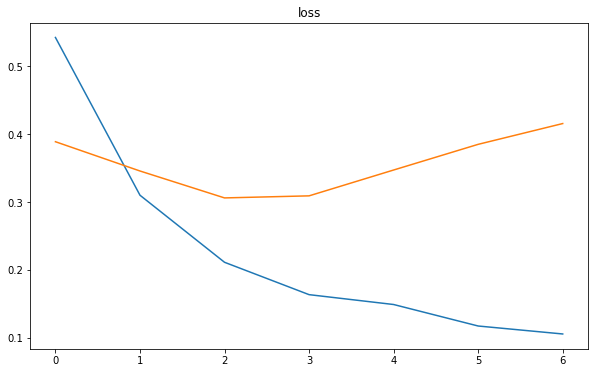

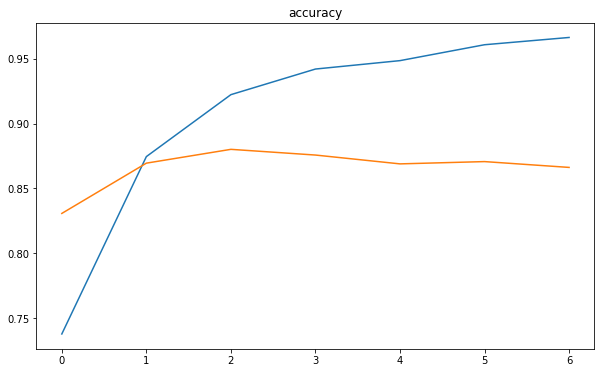

In [ ]:
model_LSTM = keras.models.Sequential()
model_LSTM.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_LSTM.add(keras.layers.LSTM(32))
model_LSTM.add(keras.layers.Dense(1, activation="sigmoid"))

model_LSTM.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model_LSTM.summary()

history = model_LSTM.fit(X_train_trim, y_train,
                    epochs=7, batch_size=128, validation_data=(X_valid_trim, y_valid))

plot_loss(history)

plot_accuracy(history)

scores = model_LSTM.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_LSTM.metrics_names[1], scores[1]*100))

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 10)          100000    
_________________________________________________________________
gru (GRU)                    (None, 32)                4224      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 104,257
Trainable params: 104,257
Non-trainable params: 0
_________________________________________________________________
Epoch 1/7
196/196 [==============================] - 7s 26ms/step - loss: 0.6297 - accuracy: 0.6079 - val_loss: 0.3382 - val_accuracy: 0.8546
Epoch 2/7
196/196 [==============================] - 5s 24ms/step - loss: 0.2773 - accuracy: 0.8929 - val_loss: 0.3087 - val_accuracy: 0.8742
Epoch 3/7
196/196 [==============================] - 5s 23ms/step - loss: 0.2036 - accuracy: 0

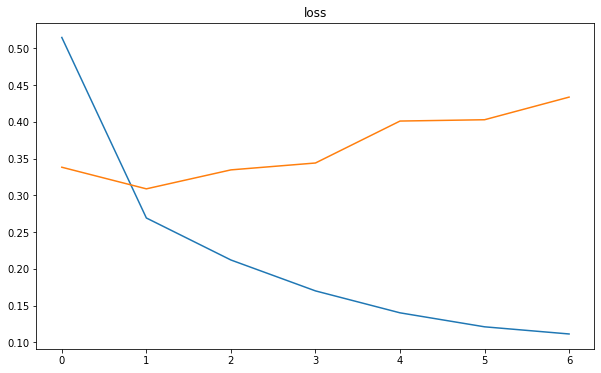

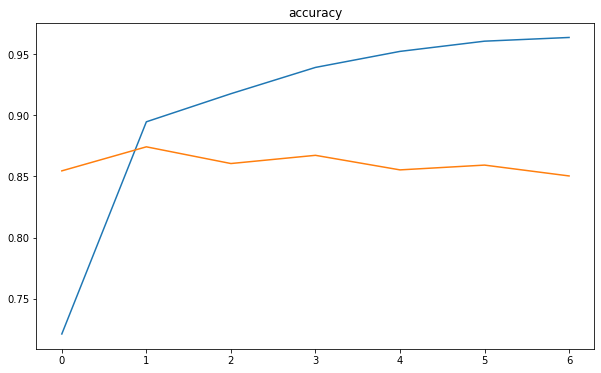

In [ ]:
model_GRU = keras.models.Sequential()
model_GRU.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_GRU.add(keras.layers.GRU(32))
model_GRU.add(keras.layers.Dense(1, activation="sigmoid"))

model_GRU.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model_GRU.summary()

history = model_GRU.fit(X_train_trim, y_train,
                    epochs=7, batch_size=128, validation_data=(X_valid_trim, y_valid))
plot_loss(history) 

plot_accuracy(history)

scores = model_GRU.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_GRU.metrics_names[1], scores[1]*100))

# Fair comparison

To get a fair comparison I reduced the number of units of the LSTM and GRU layers, so the three models have more or less the same number of parameters (about 101,400). I use 14 units for LSTM and 17 for GRU. The GRU layer has more units because it is a simpler version of the LSTM and obviously both layers have fewer units than the SimpleRNN (32). In this case the model with the best performance is the one with the LSTM layer. It achieves an accuracy in the test set of 86.95%, so it performs slightly better than the one with 32 units which has an accuracy of 86.78%.

In [ ]:
model_LSTM_fc = keras.models.Sequential()
model_LSTM_fc.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_LSTM_fc.add(keras.layers.LSTM(14))
model_LSTM_fc.add(keras.layers.Dense(1, activation="sigmoid"))

model_LSTM_fc.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model_LSTM_fc.summary()


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 10)          100000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 14)                1400      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 15        
Total params: 101,415
Trainable params: 101,415
Non-trainable params: 0
_________________________________________________________________


Epoch 1/7
196/196 [==============================] - 6s 25ms/step - loss: 0.6605 - accuracy: 0.5854 - val_loss: 0.5066 - val_accuracy: 0.7868
Epoch 2/7
196/196 [==============================] - 4s 23ms/step - loss: 0.4318 - accuracy: 0.8334 - val_loss: 0.3868 - val_accuracy: 0.8348
Epoch 3/7
196/196 [==============================] - 5s 23ms/step - loss: 0.3080 - accuracy: 0.8826 - val_loss: 0.3313 - val_accuracy: 0.8648
Epoch 4/7
196/196 [==============================] - 4s 23ms/step - loss: 0.2352 - accuracy: 0.9149 - val_loss: 0.3315 - val_accuracy: 0.8624
Epoch 5/7
196/196 [==============================] - 4s 23ms/step - loss: 0.1884 - accuracy: 0.9357 - val_loss: 0.3227 - val_accuracy: 0.8688
Epoch 6/7
196/196 [==============================] - 4s 23ms/step - loss: 0.1480 - accuracy: 0.9542 - val_loss: 0.3464 - val_accuracy: 0.8675
Epoch 7/7
196/196 [==============================] - 4s 23ms/step - loss: 0.1278 - accuracy: 0.9620 - val_loss: 0.3711 - val_accuracy: 0.8632
391/39

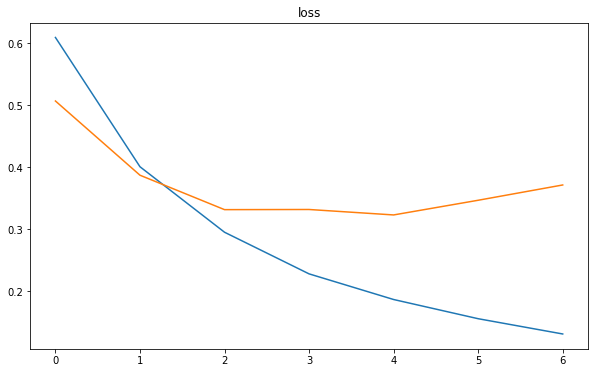

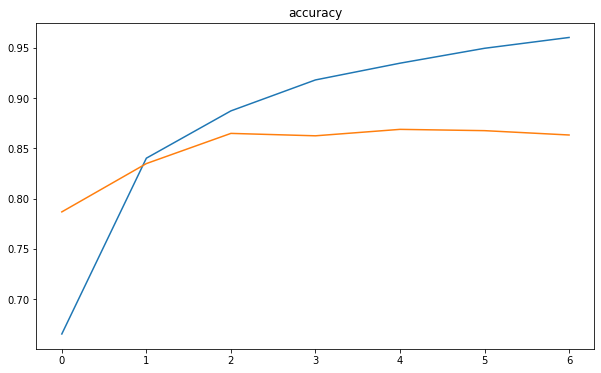

In [ ]:
history = model_LSTM_fc.fit(X_train_trim, y_train,
                    epochs=7, batch_size=128, validation_data=(X_valid_trim, y_valid))

plot_loss(history)

plot_accuracy(history)

scores = model_LSTM_fc.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_LSTM_fc.metrics_names[1], scores[1]*100))

In [ ]:
model_GRU_fc = keras.models.Sequential()
model_GRU_fc.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_GRU_fc.add(keras.layers.GRU(17))
model_GRU_fc.add(keras.layers.Dense(1, activation="sigmoid"))

model_GRU_fc.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model_GRU_fc.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 10)          100000    
_________________________________________________________________
gru_1 (GRU)                  (None, 17)                1479      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 18        
Total params: 101,497
Trainable params: 101,497
Non-trainable params: 0
_________________________________________________________________


Epoch 1/7
196/196 [==============================] - 7s 25ms/step - loss: 0.6586 - accuracy: 0.5793 - val_loss: 0.3779 - val_accuracy: 0.8361
Epoch 2/7
196/196 [==============================] - 5s 23ms/step - loss: 0.3174 - accuracy: 0.8703 - val_loss: 0.3325 - val_accuracy: 0.8610
Epoch 3/7
196/196 [==============================] - 5s 23ms/step - loss: 0.2231 - accuracy: 0.9170 - val_loss: 0.3266 - val_accuracy: 0.8655
Epoch 4/7
196/196 [==============================] - 5s 23ms/step - loss: 0.1845 - accuracy: 0.9359 - val_loss: 0.3636 - val_accuracy: 0.8608
Epoch 5/7
196/196 [==============================] - 5s 23ms/step - loss: 0.1530 - accuracy: 0.9505 - val_loss: 0.3880 - val_accuracy: 0.8618
Epoch 6/7
196/196 [==============================] - 5s 23ms/step - loss: 0.1348 - accuracy: 0.9564 - val_loss: 0.3967 - val_accuracy: 0.8574
Epoch 7/7
196/196 [==============================] - 5s 23ms/step - loss: 0.1177 - accuracy: 0.9628 - val_loss: 0.4358 - val_accuracy: 0.8523
391/39

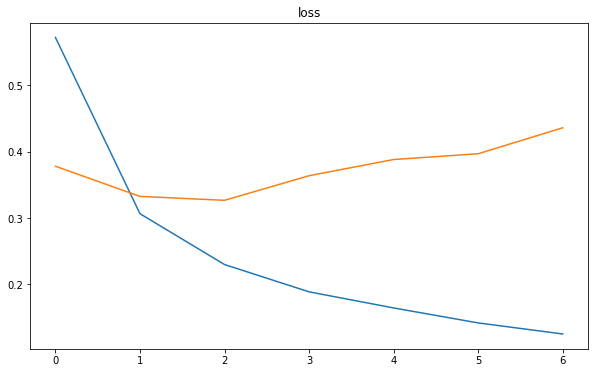

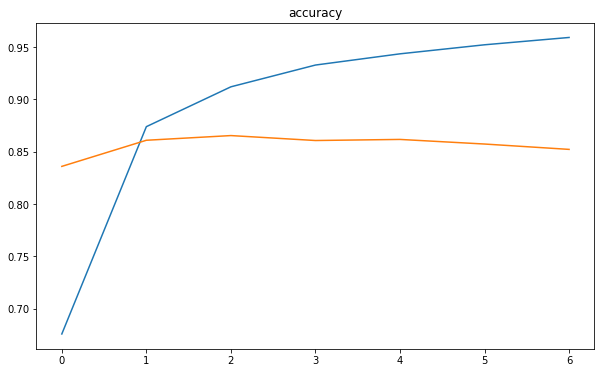

In [ ]:

history = model_GRU_fc.fit(X_train_trim, y_train,
                    epochs=7, batch_size=128, validation_data=(X_valid_trim, y_valid))
plot_loss(history)

plot_accuracy(history)
scores = model_GRU_fc.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_GRU_fc.metrics_names[1], scores[1]*100))

##Bidirectional LSTM
Let's modify the previous code by using a bidirectional LSTM instead of a simple LSTM. In Keras, it is possible to define a bidirectional layer by using [tf.keras.layers.Bidirectional](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional). Note that this wrapper requires as argument a layer, in our case we use [tf.keras.layers.LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM)


In [ ]:
model_bidirectional = keras.models.Sequential()
model_bidirectional.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_bidirectional.add(keras.layers.Bidirectional(keras.layers.LSTM(32)))
model_bidirectional.add(keras.layers.Dense(1, activation="sigmoid"))

model_bidirectional.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model_bidirectional.summary()

history = model_bidirectional.fit(X_train_trim, y_train,
                    epochs=7, batch_size=128, validation_data=(X_valid_trim, y_valid))

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 10)          100000    
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                11008     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 111,073
Trainable params: 111,073
Non-trainable params: 0
_________________________________________________________________
Epoch 1/7
196/196 [==============================] - 11s 46ms/step - loss: 0.6385 - accuracy: 0.6231 - val_loss: 0.4095 - val_accuracy: 0.8266
Epoch 2/7
196/196 [==============================] - 8s 42ms/step - loss: 0.3128 - accuracy: 0.8806 - val_loss: 0.3005 - val_accuracy: 0.8744
Epoch 3/7
196/196 [==============================] - 8s 42ms/step - loss: 0.2080 - accuracy: 

391/391 - 5s - loss: 0.4060 - accuracy: 0.8646
accuracy: 86.46%


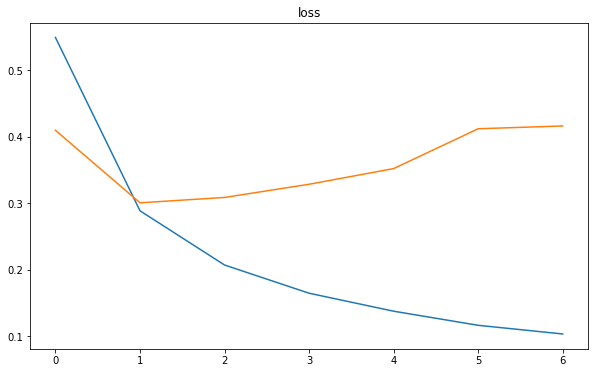

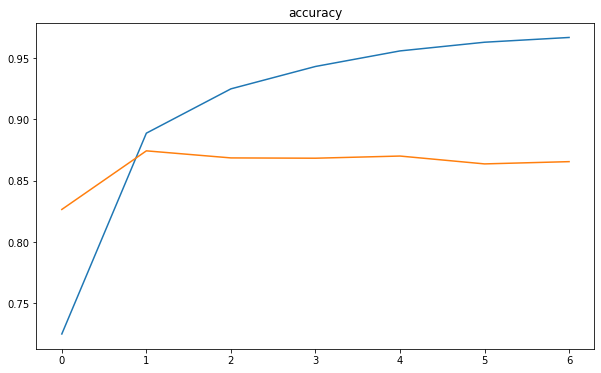

In [ ]:
plot_loss(history)

plot_accuracy(history)

scores = model_bidirectional.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_bidirectional.metrics_names[1], scores[1]*100))

##Dropout
In the bi-directional model is it possible to notice that the model overfits the training data.
A possible solution to this problem could be applying the dropout technique to input or output layers.

In Keras, to apply dropout you have to add a [keras.layers.Dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) layer.

modify the code of the previous exercise adding the Dropout to the input and/or output layers. Find the Dropout probability that reduces the overfitting issue.
Is it possible to modify the values of some other hyper-parameters to mitigate overfitting? And if this is the case, explain why and perform an experimental study demonstrating your point.


To reduce overfitting I try to add two Dropout layers, one before and one after the Bidirectional layer. After, to try to reduce even more overfitting, I try to change the number of units in the Bidirectional layer and I also try different batch sizes.

Find the best Dropout rate for the layer before the Dense Layer. In this case the best rate is 0.5

In [ ]:
parameters = [0.01, 0.05, 0.1, 0.2, 0.5] 
evolution_dropout = []

for rt in parameters:
  model_bidirectional_dpout = keras.models.Sequential()
  model_bidirectional_dpout.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
  model_bidirectional_dpout.add(keras.layers.Bidirectional(keras.layers.LSTM(32)))
  model_bidirectional_dpout.add(tf.keras.layers.Dropout(rate = rt))
  model_bidirectional_dpout.add(keras.layers.Dense(1, activation="sigmoid"))

  model_bidirectional_dpout.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

  model_bidirectional_dpout.summary()

  history = model_bidirectional_dpout.fit(X_train_trim, y_train,
                      epochs=5, batch_size=128, validation_data=(X_valid_trim, y_valid))
  evolution_dropout.append(history)

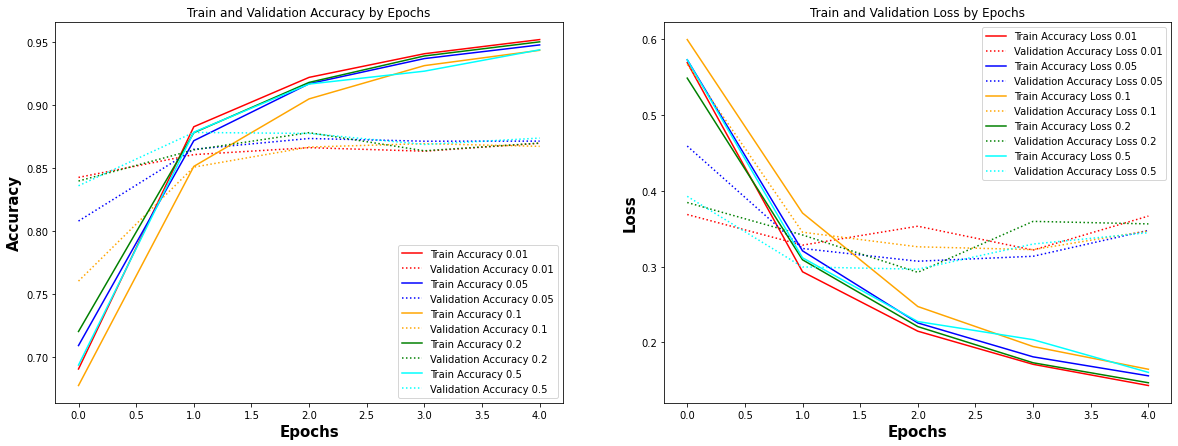

In [ ]:
plot_accuracy_loss(evolution_dropout, len(parameters), parameters)

To reduce overfitting I also try to add a Dropout Layer before the Bidirectional one. In this case the best rate is 0.5

In [ ]:
parameters = [0.05, 0.1, 0.2, 0.5] 
evolution_dropout = []

for rt in parameters:
  model_bidirectional_dpout = keras.models.Sequential()
  model_bidirectional_dpout.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
  model_bidirectional_dpout.add(tf.keras.layers.Dropout(rate = rt))
  model_bidirectional_dpout.add(keras.layers.Bidirectional(keras.layers.LSTM(32)))
  model_bidirectional_dpout.add(tf.keras.layers.Dropout(rate = 0.5))
  model_bidirectional_dpout.add(keras.layers.Dense(1, activation="sigmoid"))

  model_bidirectional_dpout.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

  model_bidirectional_dpout.summary()

  history = model_bidirectional_dpout.fit(X_train_trim, y_train,
                      epochs=5, batch_size=128, validation_data=(X_valid_trim, y_valid))
  evolution_dropout.append(history)

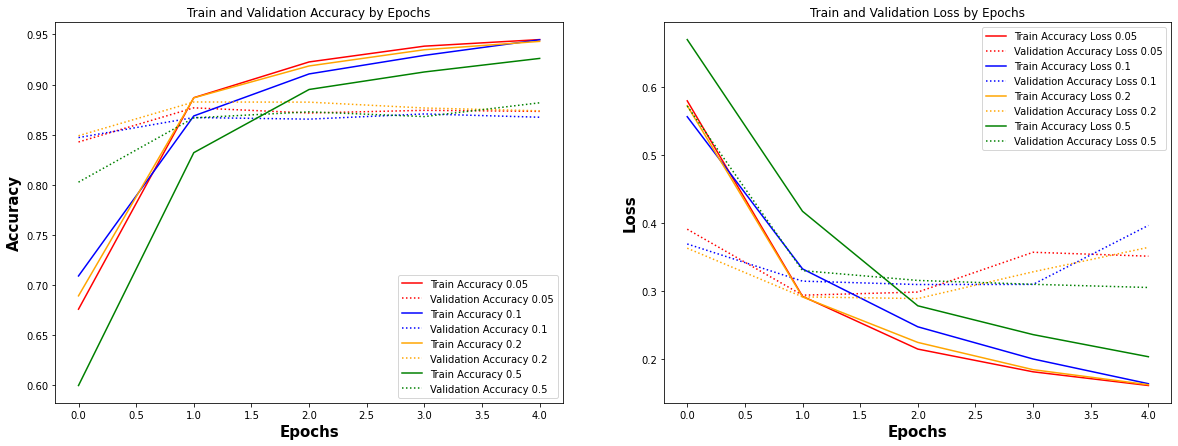

In [ ]:
plot_accuracy_loss(evolution_dropout, len(parameters), parameters)

Another possibility to reduce overfitting is to simplify the model. To do this I try to reduce the number of units in the Bidirectional layer. The model with less overfitting is the one with 32 units (so 64 in total because of Bidirectional). So decrease the number of unit in this case doesn't help.

In [ ]:
units = [8, 16, 32, 64]
evolution_units = []

for u in units:
  model_bidirectional_dpout = keras.models.Sequential()
  model_bidirectional_dpout.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
  model_bidirectional_dpout.add(tf.keras.layers.Dropout(rate = 0.5))
  model_bidirectional_dpout.add(keras.layers.Bidirectional(keras.layers.LSTM(u)))
  model_bidirectional_dpout.add(tf.keras.layers.Dropout(rate = 0.5))
  model_bidirectional_dpout.add(keras.layers.Dense(1, activation="sigmoid"))

  model_bidirectional_dpout.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

  model_bidirectional_dpout.summary()

  history = model_bidirectional_dpout.fit(X_train_trim, y_train,
                      epochs=5, batch_size=128, validation_data=(X_valid_trim, y_valid))
  evolution_units.append(history)

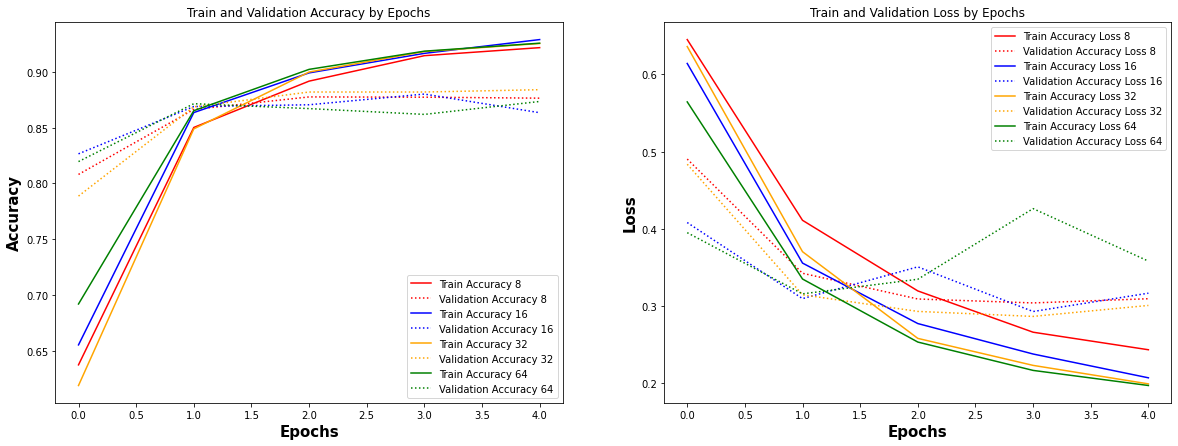

In [ ]:
plot_accuracy_loss(evolution_units, len(units), units)

Finally, to see if I can reduce overfitting, I also try to change the batch size. From the plots we can see that changing this hyperparameter doesn't help much to reduce overfitting. The worst model is the one with batch size equal to 32, both in accuracy and time performance, while the other are very similar.

In [ ]:
batches = [32, 64, 128, 256]
evolution_batch = []

for bs in batches:
  model_bidirectional_dpout = keras.models.Sequential()
  model_bidirectional_dpout.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
  model_bidirectional_dpout.add(tf.keras.layers.Dropout(rate = 0.5))
  model_bidirectional_dpout.add(keras.layers.Bidirectional(keras.layers.LSTM(32)))
  model_bidirectional_dpout.add(tf.keras.layers.Dropout(rate = 0.5))
  model_bidirectional_dpout.add(keras.layers.Dense(1, activation="sigmoid"))

  model_bidirectional_dpout.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

  model_bidirectional_dpout.summary()

  history = model_bidirectional_dpout.fit(X_train_trim, y_train,
                      epochs=5, batch_size= bs, validation_data=(X_valid_trim, y_valid))
  evolution_batch.append(history)

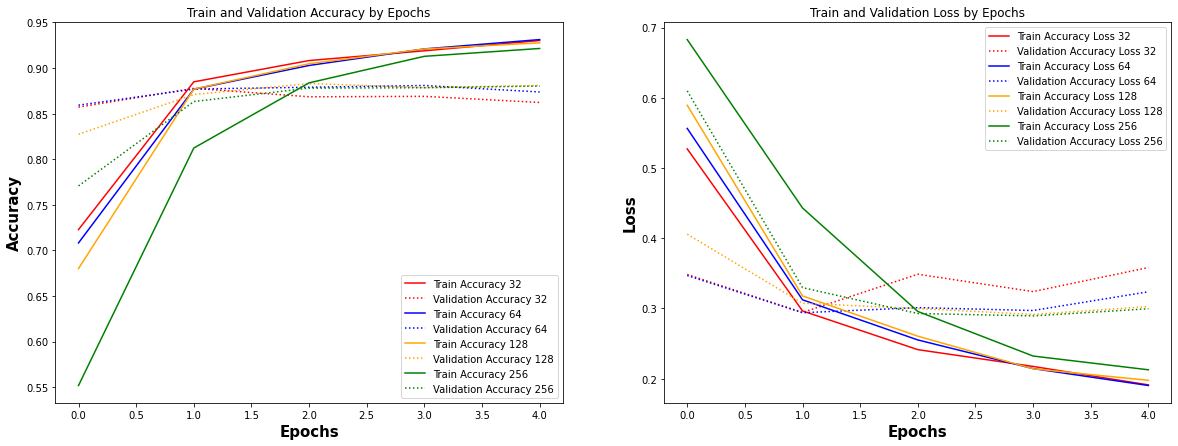

In [ ]:
plot_accuracy_loss(evolution_batch, len(batches), batches)